In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Bucketing

The core of a good skorecard models is to bucket the features.

This section showcases how to use skorecard to achieve this.

Let's start by loading the demo data

In [2]:
from skorecard.datasets import load_credit_card
data = load_credit_card(as_frame=True)

In [3]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x15,x16,x17,x18,x19,x20,x21,x22,x23,y
0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


The dataset used contains 30K rows, 23 features and a binary target.

Let's start by splitting the data in train and test sample, as per common practice when building a model.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['y'], axis=1),
    data['y'], 
    test_size=0.25, 
    random_state=42
)

#### Define the numerical and categorical features

The features `x2`, `x3` and `x4` are of categorical nature

In [5]:
cat_cols = ['x2','x3','x4']
num_cols = [col for col in X_train.columns if col not in cat_cols]

print(f"Total categorical columns: {len(cat_cols)}")
print(f"Total numerical columns: {len(num_cols)}")

Total categorical columns: 3
Total numerical columns: 20


# Bucketing features

Skorecard implements different bucketers, but they are not applicable to all the features.

- **Categorical features**: 
In most of the cases, there is no numerical relationship between categories.<br>
Therefore automatic bucketing is very difficult to perform. <br>
`skorecard` implements the `OrdinalCategoricalBucketer` that orders the buckets either by the count or by the target rate.<br> 
It includes a tolerance (`tol`) input, which represent the lower bound of the fraction of data allowed to keep a category in the same

- **Numerical features**: 
differently from categorical features, algorithmic bucketing can be applied to numerical features.
`skorecard` implements different bucketers that can be used for numerical features:
    - `DecisionTreeBucketer`: fits a univariate decision tree to find the optimal splits (requires the target `y`)
    - `EqualWidthBucketer`: generates buckets with equal spacing in the bucket boundaries (ie historgrams)
    - `EqualFrequencyBucketer`: generates buckets with equal counts in the buckets (ie quantiles)
    - `AgglomerativeClusteringBucketer`: generates bucketes by applying AgglomerativeClustering (density based bucketer)



### Manual correction

Note: to build a high quality scorecard, it's highly recommended to assess manually every bucket.
Algorithms implemented in `skorecard` are very helpful, but are obscure to the business sense.<br>
This is especially true for categorical features, where business sense should prevail.





## Default bucketers

### Categorical features

Due to (generally speaking) no relationship between categories, it's not possible to implement an algorithmic way of bucketing the values (in the same way as it is possible for numerical features). <br>
The only suitable bucketer for categorical features in `skorecard` is the ordinal categorical bucketer, which groups together low-frequency categrical variables (all variables with a frequency below the `tol` threshold are put in the `other` bucket)

Let's fix the tol to `5%`, as this is the recommended minimum.

In [6]:
# Start with categorical features
from skorecard.bucketers import OrdinalCategoricalBucketer


In [7]:
cat_bucketer = OrdinalCategoricalBucketer(variables=cat_cols, tol = 0.05, encoding_method='ordered')

cat_bucketer.fit(X_train,y_train)

OrdinalCategoricalBucketer(encoding_method='ordered',
                           variables=['x2', 'x3', 'x4'])

**Example: Look up the feature 'x3'**

The feature 'x3' has a few categories that are sparesely-populated

In [8]:
X_train['x3'].value_counts(normalize=True)

2.0    0.466311
1.0    0.354089
3.0    0.163911
5.0    0.009333
4.0    0.004089
6.0    0.001822
0.0    0.000444
Name: x3, dtype: float64

The OrdinalCategorical bucketer populates the `other` category with sparse values

In [9]:
cat_bucketer.bucket_table('x3')

,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-2,Other,353.0,1.57,326.0,27.0,0.076487,1.239,-0.016
1,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
2,0,1.0,7967.0,35.41,6445.0,1522.0,0.191038,0.193,-0.012
3,1,2.0,10492.0,46.63,7965.0,2527.0,0.240850,-0.102,-0.005
4,2,3.0,3688.0,16.39,2755.0,933.0,0.252983,-0.168,-0.005


**Note**
There might be a different strategy applied to different bucketers.<br>
This is addressed by defining a pipeline of bucketers (see the numerical features section for details)

### Numerical features

Numerical features allow for different bucketers (as described above).

However, the recommended approach for bucketing is to use either the `DecisionTreeBucketer` or the `BucketingProcess`.



In [10]:
X_train['x1'].value_counts()

50000.0      2510
20000.0      1470
30000.0      1218
80000.0      1173
200000.0     1151
             ... 
650000.0        1
1000000.0       1
730000.0        1
690000.0        1
327680.0        1
Name: x1, Length: 79, dtype: int64

In [11]:
from skorecard.bucketers import DecisionTreeBucketer

specials = {'x1':{'special_demo':[50000]}}

num_bucketer = DecisionTreeBucketer(variables=num_cols, 
                                   max_n_bins=5, #max number of bins allowed
                                   min_bin_size=0.06, # min fraction of data allowed in the bin
                                   criterion="entropy", 
                                   min_impurity_decrease=0.0005, #as in sklearn. Helps to decide how to split the buckets
                                   specials=specials
                                   )
num_bucketer.fit(X_train, y_train)

DecisionTreeBucketer(max_n_bins=5, min_bin_size=0.06,
                     specials={'x1': {'special_demo': [50000]}},
                     variables=['x1', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
                                'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17',
                                'x18', 'x19', 'x20', 'x21', 'x22', 'x23'])

In [12]:
num_bucketer.bucket_table('x1')

,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-3,Special: special_demo,2510.0,11.16,1848.0,662.0,0.263745,-0.224,-0.006
1,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
2,0,"[-inf, 75000.0)",4399.0,19.55,2880.0,1519.0,0.345306,-0.611,-0.085
3,1,"[75000.0, 145000.0)",4567.0,20.30,3494.0,1073.0,0.234946,-0.070,-0.001
4,2,"[145000.0, 375000.0)",9230.0,41.02,7685.0,1545.0,0.167389,0.354,-0.046
5,3,"[375000.0, inf)",1794.0,7.97,1584.0,210.0,0.117057,0.770,-0.037


### See the bucket outputs (for the first three features)

In [13]:
for x in num_cols[:3]:
    display(num_bucketer.fit(X_train, y_train).bucket_table(x))

,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-3,Special: special_demo,2510.0,11.16,1848.0,662.0,0.263745,-0.224,-0.006
1,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
2,0,"[-inf, 75000.0)",4399.0,19.55,2880.0,1519.0,0.345306,-0.611,-0.085
3,1,"[75000.0, 145000.0)",4567.0,20.30,3494.0,1073.0,0.234946,-0.070,-0.001
4,2,"[145000.0, 375000.0)",9230.0,41.02,7685.0,1545.0,0.167389,0.354,-0.046
5,3,"[375000.0, inf)",1794.0,7.97,1584.0,210.0,0.117057,0.770,-0.037


,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
1,0,"[-inf, 25.5)",2927.0,13.01,2143.0,784.0,0.267851,-0.245,-0.008
2,1,"[25.5, 35.5)",9664.0,42.95,7750.0,1914.0,0.198055,0.148,-0.009
3,2,"[35.5, inf)",9909.0,44.04,7598.0,2311.0,0.233222,-0.060,-0.002


,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
1,0,"[-inf, -0.5)",6370.0,28.31,5361.0,1009.0,0.158399,0.420,-0.044
2,1,"[-0.5, 0.5)",11032.0,49.03,9620.0,1412.0,0.127991,0.668,-0.179
3,2,"[0.5, 1.5)",2720.0,12.09,1796.0,924.0,0.339706,-0.586,-0.048
4,3,"[1.5, inf)",2378.0,10.57,714.0,1664.0,0.699748,-2.096,-0.611


### With different bucketers for different feature in one go

In [14]:
from sklearn.pipeline import make_pipeline
from skorecard.bucketers import EqualFrequencyBucketer, DecisionTreeBucketer

pipe = make_pipeline(
    EqualFrequencyBucketer(n_bins=5, variables=num_cols[:5]),
    DecisionTreeBucketer(max_n_bins=5, variables=num_cols[5:])
)
pipe.fit(X_train, y_train)

/Users/iv58uq/Documents/open_source/skorecard/skorecard/bucketers/bucketers.py:691: ApproximationWarning: Approximated quantiles - too many unique values
  "Approximated quantiles - too many unique values"
/Users/iv58uq/Documents/open_source/skorecard/skorecard/bucketers/bucketers.py:691: ApproximationWarning: Approximated quantiles - too many unique values
  "Approximated quantiles - too many unique values"
/Users/iv58uq/Documents/open_source/skorecard/skorecard/bucketers/bucketers.py:691: ApproximationWarning: Approximated quantiles - too many unique values
  "Approximated quantiles - too many unique values"


Pipeline(steps=[('equalfrequencybucketer',
                 EqualFrequencyBucketer(variables=['x1', 'x5', 'x6', 'x7',
                                                   'x8'])),
                ('decisiontreebucketer',
                 DecisionTreeBucketer(max_n_bins=5,
                                      variables=['x9', 'x10', 'x11', 'x12',
                                                 'x13', 'x14', 'x15', 'x16',
                                                 'x17', 'x18', 'x19', 'x20',
                                                 'x21', 'x22', 'x23']))])

In [15]:
pipe.transform(X_test)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
2308,0,1.0,2.0,2.0,0,1,1,1,2,2,...,2,1,3,3,1,2,1,1,1,1
22404,2,2.0,1.0,2.0,0,1,1,1,2,2,...,4,4,4,4,2,2,2,3,2,2
23397,1,2.0,3.0,1.0,2,1,1,1,2,2,...,3,4,4,4,1,2,2,2,1,2
25058,2,1.0,3.0,2.0,4,1,1,1,2,2,...,2,2,2,1,1,2,3,1,3,2
2664,0,2.0,2.0,2.0,2,1,1,1,2,2,...,3,2,3,3,1,1,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0,2.0,3.0,1.0,4,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
9355,4,2.0,2.0,1.0,3,1,1,1,2,2,...,2,3,3,4,3,3,3,3,3,2
28201,4,2.0,3.0,2.0,4,2,2,2,1,2,...,0,0,1,0,1,0,1,1,1,0
19705,1,2.0,2.0,1.0,4,0,0,0,1,1,...,0,1,0,0,3,0,3,0,0,0


### Parenthesis: compare the buckets from two different algorithms

By comparing the `DecisionTreeBucketer` in the first example, and the `EqualFrequencyBucketer` from the pipeline example, here comes a quick preview on assessing the two bucketing results.<br>

The first case results in the higher IV, with less buckets, hence it's definetely a better result!

In [16]:
print(f"\nDecisionTreeBucketer, with IV: {num_bucketer.bucket_table(num_cols[0])['IV'].sum()}")
display(num_bucketer.bucket_table(num_cols[0]))

print(f"\nEqualFrequencyBucketer, with IV: {pipe.steps[0][1].bucket_table(num_cols[0])['IV'].sum()}")
display(pipe.steps[0][1].bucket_table(num_cols[0]))



DecisionTreeBucketer, with IV: -0.17500000000000002


,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-3,Special: special_demo,2510.0,11.16,1848.0,662.0,0.263745,-0.224,-0.006
1,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
2,0,"[-inf, 75000.0)",4399.0,19.55,2880.0,1519.0,0.345306,-0.611,-0.085
3,1,"[75000.0, 145000.0)",4567.0,20.30,3494.0,1073.0,0.234946,-0.070,-0.001
4,2,"[145000.0, 375000.0)",9230.0,41.02,7685.0,1545.0,0.167389,0.354,-0.046
5,3,"[375000.0, inf)",1794.0,7.97,1584.0,210.0,0.117057,0.770,-0.037



EqualFrequencyBucketer, with IV: -0.159


,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
1,0,"(-inf, 50000.0]",5741.0,25.52,3885.0,1856.0,0.323289,-0.512,-0.076
2,1,"(50000.0, 100000.0]",3613.0,16.06,2691.0,922.0,0.255190,-0.179,-0.005
3,2,"(100000.0, 180000.0]",4629.0,20.57,3711.0,918.0,0.198315,0.146,-0.004
4,3,"(180000.0, 270000.0]",4062.0,18.05,3362.0,700.0,0.172329,0.319,-0.017
5,4,"(270000.0, inf]",4455.0,19.80,3842.0,613.0,0.137598,0.585,-0.057


## Make a pipeline for all the features
So far, it was shown how to deal with bucketers for categoricals/numericals.

The whole process can be put together as in a scikit learn pipeline.

In [17]:
bucketing_pipe = make_pipeline(
    num_bucketer,
    cat_bucketer
)
bucketing_pipe.fit(X_train, y_train)

Pipeline(steps=[('decisiontreebucketer',
                 DecisionTreeBucketer(max_n_bins=5, min_bin_size=0.06,
                                      specials={'x1': {'special_demo': [50000]}},
                                      variables=['x1', 'x5', 'x6', 'x7', 'x8',
                                                 'x9', 'x10', 'x11', 'x12',
                                                 'x13', 'x14', 'x15', 'x16',
                                                 'x17', 'x18', 'x19', 'x20',
                                                 'x21', 'x22', 'x23'])),
                ('ordinalcategoricalbucketer',
                 OrdinalCategoricalBucketer(encoding_method='ordered',
                                            variables=['x2', 'x3', 'x4']))])

### Save the bucketers to file

Once the buckets are satisfactory, save the ouputs to a yaml file

## Using the bucketing process

The most common approach in bucketing is to perform what is known as `fine-coarse classing`.<br>

In less fancy words:
- you start by by very loose bucketing requirements (many buckets, where some minimal (hopefully significant) aggregations and statistics can be computed - this is known as `fine classing`
- for numerical features, it starts by merging together adiacent buckets with similar default rate/WoE 
- for categorical features, one should merge together categories with similar default rate/WoE, but only when it makes sense
- the last two steps (or merging together buckets) is known as `coarse classing`

In skorecard, this process is known as `Bucketing Process`, as shown below:

1. The bucketing process starts by defining the loose (fine) buckets (prebucketing pipeline)

2. It then runs an optimization algorithm, that merges the buckets together according to an optimization algorithm (bucketing pipeline)


In [18]:
from skorecard.bucketers import DecisionTreeBucketer, OrdinalCategoricalBucketer, OptimalBucketer
from skorecard.pipeline import BucketingProcess
from sklearn.pipeline import make_pipeline


specials = {'x1':{'special_demo':[50000]}}


prebucketing_pipeline=make_pipeline( 
    DecisionTreeBucketer(variables=num_cols, max_n_bins=40, #loose requirements
                        min_bin_size=0.03
                        ),
    OrdinalCategoricalBucketer(variables=cat_cols, tol = 0.02)
)

bucketing_pipeline=make_pipeline(
    OptimalBucketer(variables=num_cols, max_n_bins=6, min_bin_size=0.05),
    OptimalBucketer(
        variables=cat_cols,
        variables_type='categorical',
        max_n_bins=10,
        min_bin_size=0.05)
)


bucketing_process = BucketingProcess(
    prebucketing_pipeline=prebucketing_pipeline,
    bucketing_pipeline=bucketing_pipeline,
    specials=specials,
)

bucketing_process = bucketing_process.fit(X_train, y_train)

# Let's see the output of this optimization step

In [19]:
print(f"Prebucketing step (fine classing), IV {bucketing_process.prebucket_table('x1')['IV'].sum()}")
display(bucketing_process.prebucket_table('x1'))


print(f"\nBucketing step (coarse classing), IV {bucketing_process.bucket_table('x1')['IV'].sum()}")
display(bucketing_process.bucket_table('x1'))

Prebucketing step (fine classing), IV -0.192


,pre-bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV,bucket
0,-3,Special: special_demo,2510.0,11.16,1848.0,662.0,0.263745,-0.224,-0.006,-3
1,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000,0
2,0,"[-inf, 25000.0)",1830.0,8.13,1153.0,677.0,0.369945,-0.718,-0.050,0
3,1,"[25000.0, 50000.0)",1401.0,6.23,884.0,517.0,0.369022,-0.714,-0.038,0
4,2,"[50000.0, 75000.0)",1168.0,5.19,843.0,325.0,0.278253,-0.297,-0.005,1
5,3,"[75000.0, 85000.0)",1173.0,5.21,907.0,266.0,0.226769,-0.024,-0.000,2
6,4,"[85000.0, 105000.0)",1272.0,5.65,941.0,331.0,0.260220,-0.206,-0.003,2
7,5,"[105000.0, 125000.0)",995.0,4.42,770.0,225.0,0.226131,-0.020,-0.000,2
8,6,"[125000.0, 145000.0)",1127.0,5.01,876.0,251.0,0.222715,-0.001,-0.000,2
9,7,"[145000.0, 155000.0)",821.0,3.65,683.0,138.0,0.168088,0.349,-0.004,3



Bucketing step (coarse classing), IV -0.186


,bucket,label,Count,Count (%),Non-event,Event,Event Rate,WoE,IV
0,-3,Special: special_demo,2510.0,11.16,1848.0,662.0,0.263745,-0.224,-0.006
1,-1,Missing,0.0,0.00,0.0,0.0,NaN,0.000,0.000
2,0,"[-inf, 2.0)",3231.0,14.36,2037.0,1194.0,0.369545,-0.716,-0.087
3,1,"[2.0, 3.0)",1168.0,5.19,843.0,325.0,0.278253,-0.297,-0.005
4,2,"[3.0, 7.0)",4567.0,20.30,3494.0,1073.0,0.234946,-0.070,-0.001
5,3,"[7.0, 13.0)",5742.0,25.52,4723.0,1019.0,0.177464,0.283,-0.019
6,4,"[13.0, 17.0)",3488.0,15.50,2962.0,526.0,0.150803,0.478,-0.031
7,5,"[17.0, inf)",1794.0,7.97,1584.0,210.0,0.117057,0.770,-0.037


Notice in the first table there is an additional column that are the optimized buckets (those indexes are aggregated in the second table). <br>
Because of the additive nature of the IV, by reducing the number of buckets, the IV will normally decrease. <br>
The goal is to reduce the number of buckets as much as possible, by keeping a high IV value, and check for monotonicity wherever needed.

In [20]:
y_train.value_counts(normalize=True)

0    0.777378
1    0.222622
Name: y, dtype: float64

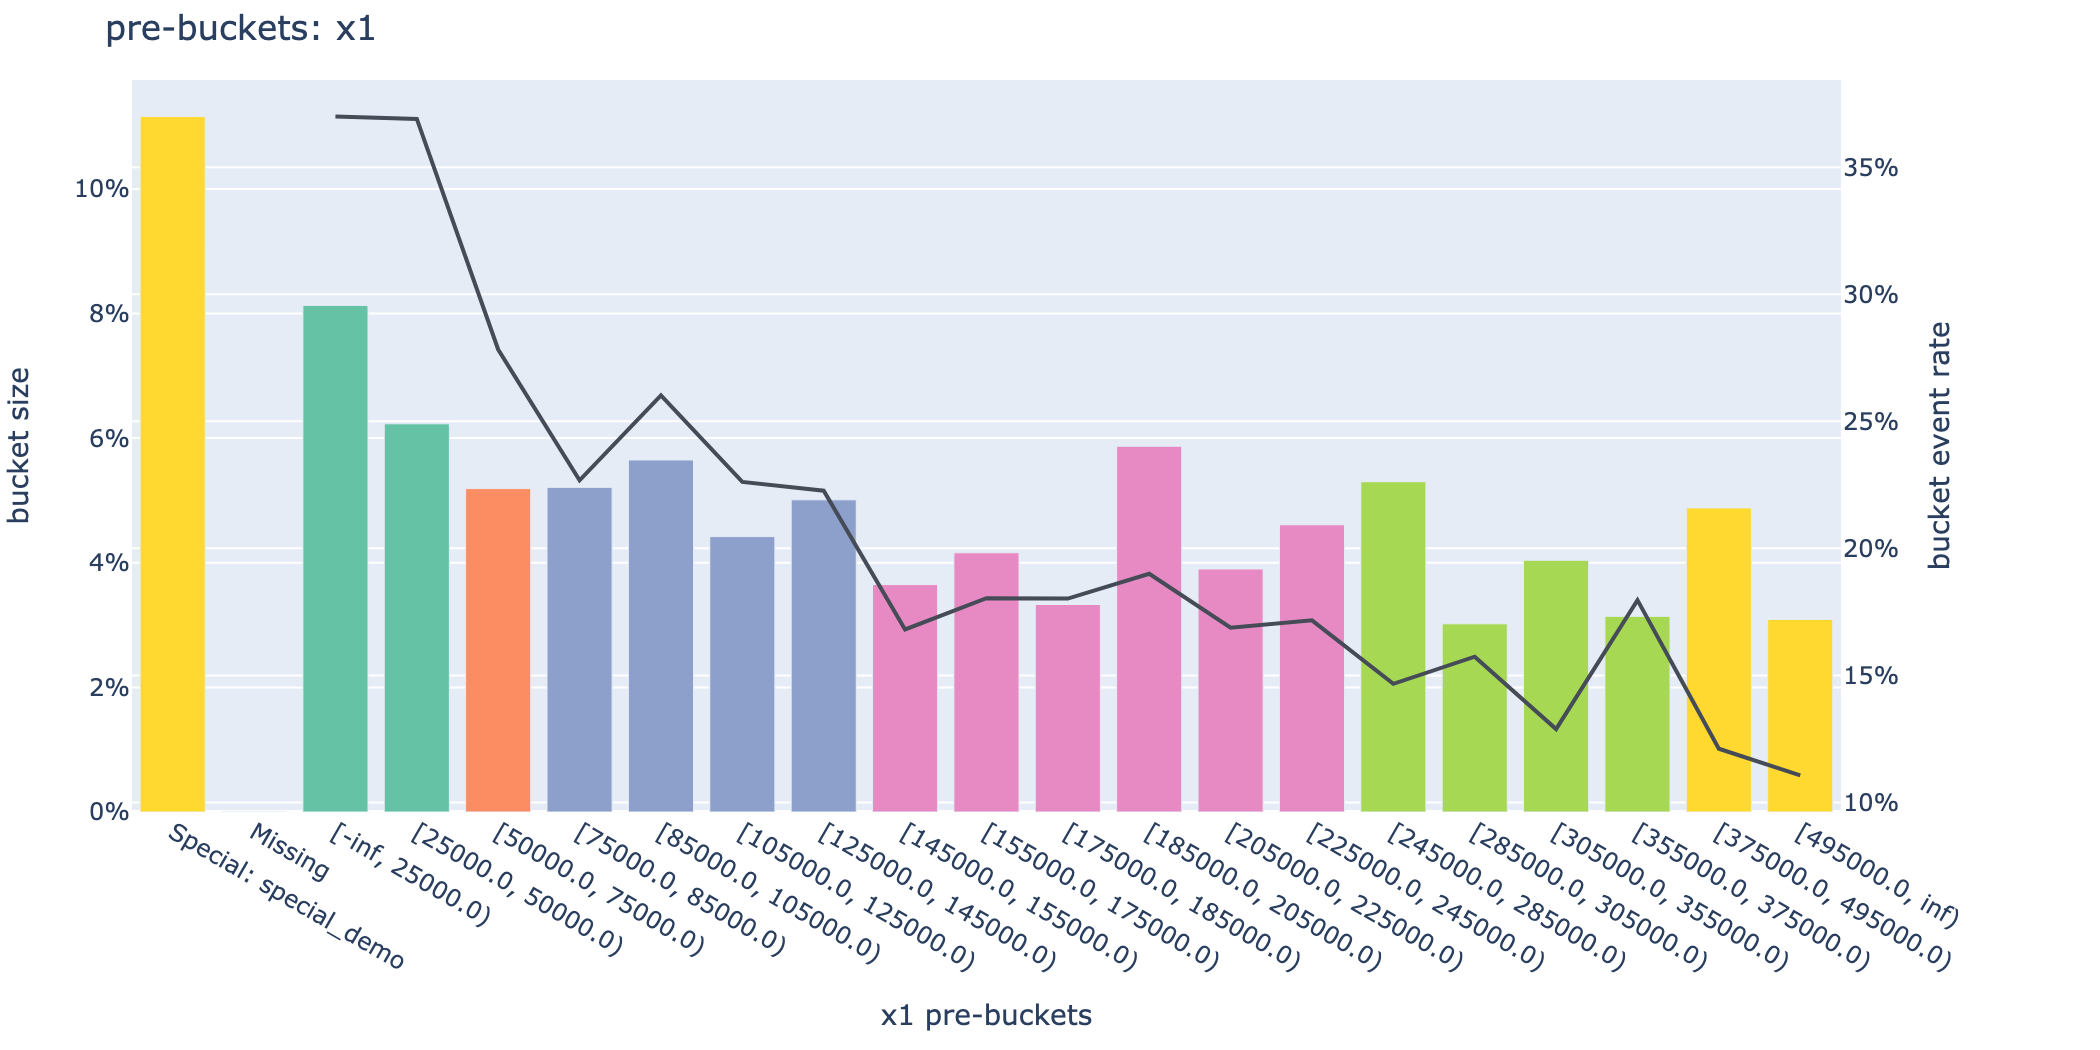

In [21]:
bucketing_process.plot_prebucket('x1', format="png", scale=2, width=1050, height=525) 

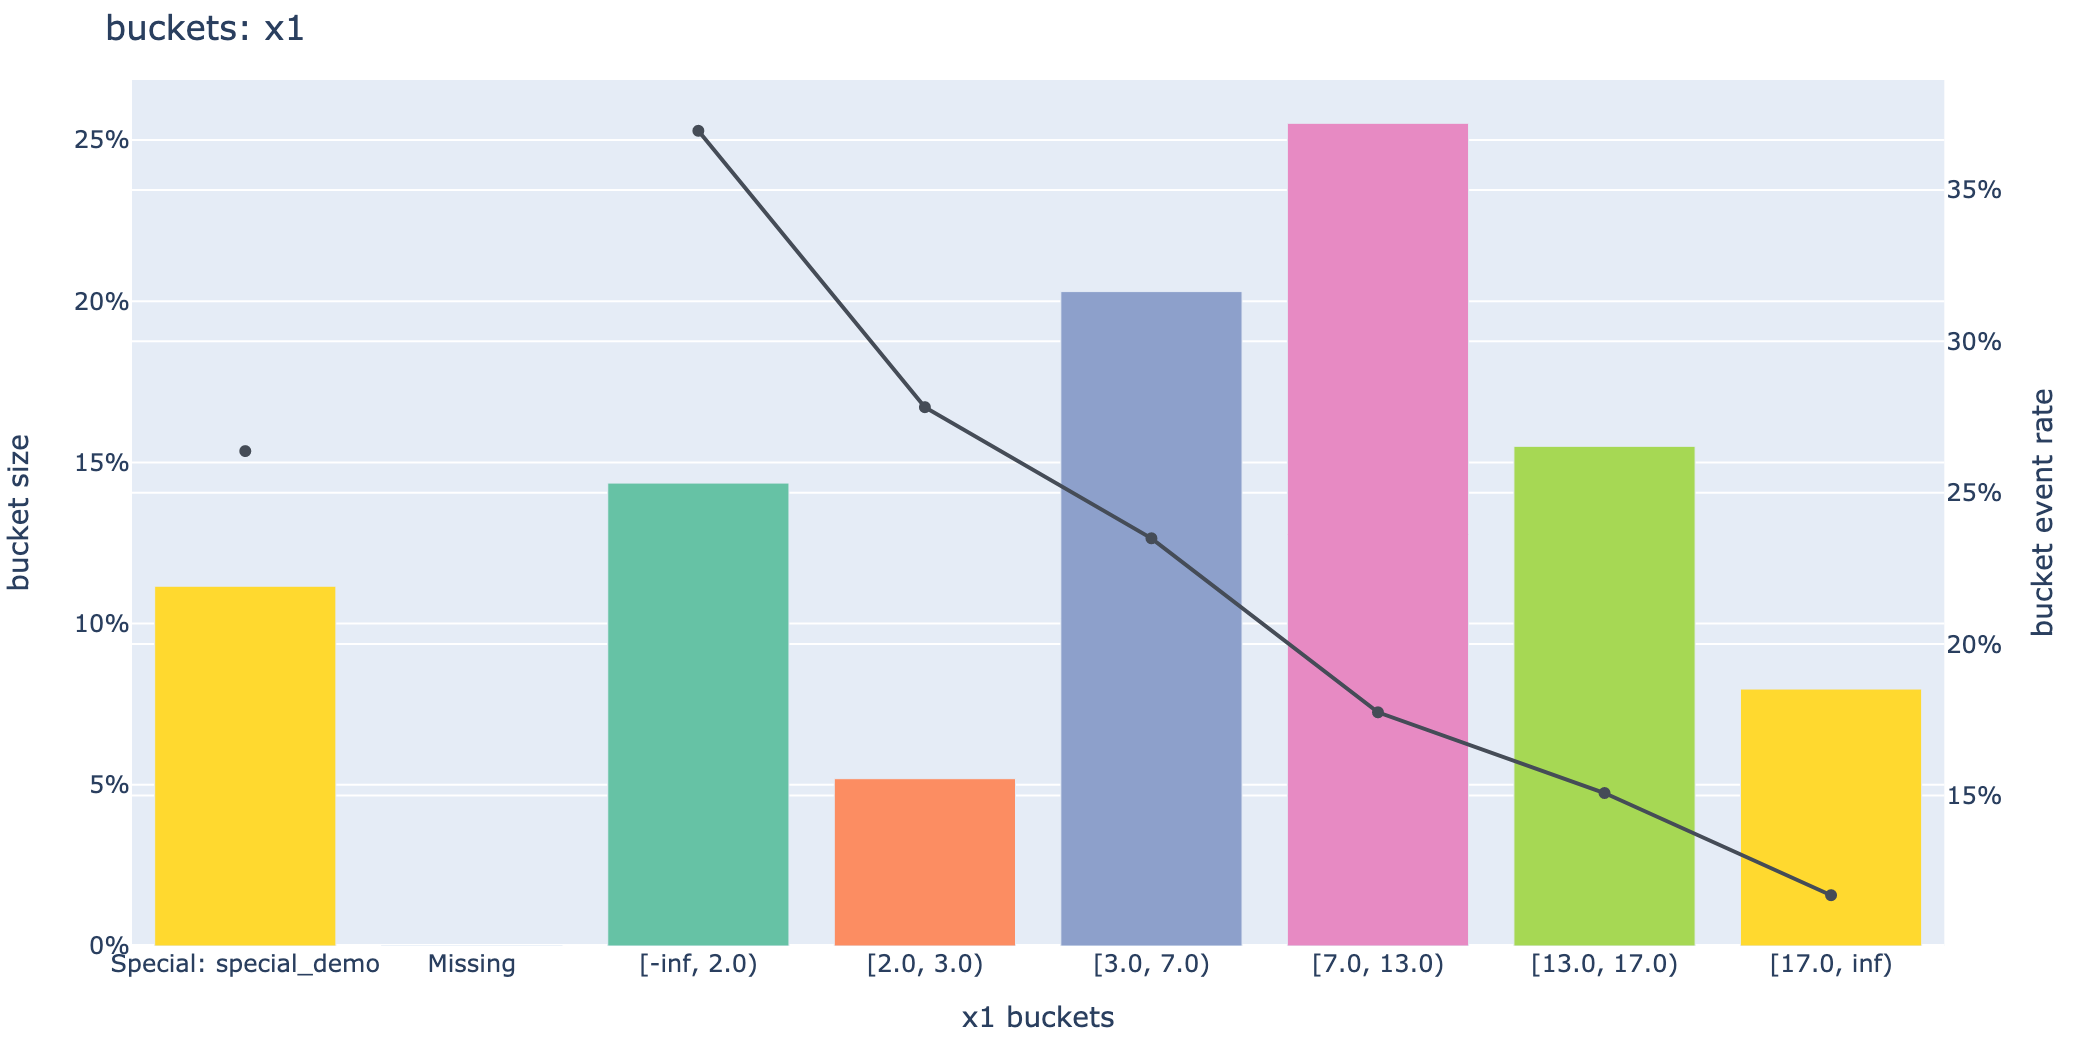

In [22]:
bucketing_process.plot_bucket('x1', format="png", scale=2, width=1050, height=525)

In [23]:
bucketing_process.summary()

,column,num_prebuckets,num_buckets,IV_score,dtype
0,x1,21,8,0.186123,float64
1,x2,4,4,0.010225,float64
2,x3,5,5,0.027332,float64
3,x4,4,4,0.005379,float64
4,x5,24,3,0.009663,float64
5,x6,6,5,0.871685,float64
6,x7,5,3,0.567571,float64
7,x8,5,4,0.431979,float64
8,x9,5,4,0.371231,float64
9,x10,5,4,0.334732,float64


In [24]:
bucketing_process.save_yml(open('best_buckeeting.yml','w'))

# Manual bucket refinement (WIP)

Besides manually inspecting, it's very often necessary to manully refine the the buckets.
`skorecard` implements a handy web-app what allows the user to redefine the bucket allocation.

This step requires the whole pipeline to be built (ie bucketing process, followed by an encoder, and then the model)

In [25]:
from sklearn.pipeline import make_pipeline
from skorecard.preprocessing import WoeEncoder
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(
    bucketing_process,
    WoeEncoder(),
    LogisticRegression()
)

pipeline = pipeline.fit(X_train, y_train)

Start the app

In [26]:
from skorecard.apps import BucketTweakerApp

tweaker = BucketTweakerApp(pipeline, X_train, y_train)

In [27]:
tweaker.run_server()

Dash app running on http://127.0.0.1:8050/


## Up next

How to perform feature selection in a `skorecard` model